<a href="https://colab.research.google.com/github/jamesmoraless/Complex-Number-Calculator/blob/main/stock_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Description: This program uses an artificial recurrent neural networlk called Long Short Term Memory (LSTM) 
# to predit a closing stock price of a corporation (apple). using the past 60 day stock price


In [4]:
import pandas as pd

#Getting the data from the CSV file 
df = pd.read_csv('MSFT.csv')
#Output of data 
df

df = df[['Date', 'Close']]
df



,Date,Close
0,2017-11-02,84.050003
1,2017-11-03,84.139999
2,2017-11-06,84.470001
3,2017-11-07,84.269997
4,2017-11-08,84.559998
...,...,...
1253,2022-10-26,231.320007
1254,2022-10-27,226.750000
1255,2022-10-28,235.869995
1256,2022-10-31,232.130005


In [5]:
import datetime
#Converting the dates into actual dates with datetime
def str_to_datetime(s):
  split_date = s.split('-')
  year, month, day = int(split_date[0]), int(split_date[1]), int(split_date[2])
  return datetime.datetime(year=year, month=month, day=day)


In [6]:
df['Date'] = df['Date'].apply(str_to_datetime)

df['Date']

0      2017-11-02
1      2017-11-03
2      2017-11-06
3      2017-11-07
4      2017-11-08
          ...    
1253   2022-10-26
1254   2022-10-27
1255   2022-10-28
1256   2022-10-31
1257   2022-11-01
Name: Date, Length: 1258, dtype: datetime64[ns]

In [7]:
df.index = df.pop('Date')
df

,Close
Date,
2017-11-02,84.050003
2017-11-03,84.139999
2017-11-06,84.470001
2017-11-07,84.269997
2017-11-08,84.559998
...,...
2022-10-26,231.320007
2022-10-27,226.750000
2022-10-28,235.869995


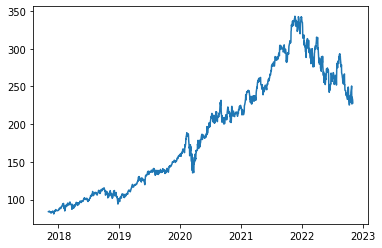

In [8]:
import matplotlib.pyplot as plt

plt.plot(df.index,df['Close'])

In [9]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [10]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

In [11]:
#Training, validation and testing to evaluate the performance of the model 
